## SNPE inference experiments: Conditional sampling and plotting

With the inference model trained with 32000 review time series (20 Marketplaces) from the simulated data, the remaining 19200 simulated review time series (12 Marketplaces) can be employed for conditional sampling and evaluation of results according to proposed experiments.

This notebook contains code in charge of drawing conditional posterior samples for time series belonging to the three groups that are relevant for the proposed experiments, to then generate a plot with the resulting posterior distributions for the parameters Rho+, Rho- and h_p for all three groups.

For further clarity, the three groups of simulations employed as part of the experiments can be charactrerized as follows: 


   __"Base" group__: Acting as the "control" group, is comprised of the 19200 simulated reviews time series not employed to train the inference model.

   __"Jumbled" group__: Built from the base group. Review time series preserve their number and distribution of reviews but the order of these is altered (i.e. Jumbled) for all products. This is the group of reference for experiment 2.

   __"Augmented" group__: Built from the base group. Review time series preserve their distribution, but the number of reviews is increased by a factor of two for all products. This is the group of reference for experiment 3.



#### Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Just a formatting related plugin
#%load_ext nb_black

%matplotlib inline
import matplotlib.pyplot as plt

import sys

sys.path.append("../")

import multiprocessing as mp

from collections import deque
from pathlib import Path
from typing import Dict, Optional

import arviz
import pickle

import numpy as np
import pandas as pd
#import pyreadr
import sbi
import sbi.utils as sbi_utils
import seaborn as sns
import statsmodels.formula.api as smf
import torch

from joblib import Parallel, delayed
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
from snpe.inference import inference_class
from snpe.simulations import simulator_class, marketplace_simulator_class
from snpe.embeddings.embeddings_to_ratings import EmbeddingRatingPredictor
from snpe.utils.statistics import review_histogram_correlation
from snpe.utils.tqdm_utils import tqdm_joblib
from tqdm import tqdm

# Set plotting parameters
sns.set(style="white", context="talk", font_scale=2.5)
sns.set_color_codes(palette="colorblind")
sns.set_style("ticks", {"axes.linewidth": 2.0})

#### Paths for retrieval of relevant components

(Adapt at convenience)

In [2]:
ARTIFACT_PATH = Path("../../../artifacts") # Simulator and Trained inference model employed during conditional sampling
SAMPLING_SIMULATION_PATH = Path("../../../sampling") # Path of simulated data (3 groups: Base, Jumbled and Augmented)

#### Define conditional posterior sampling function

(Recycled from inference tutorial)

In [3]:
def sample_posterior_with_observed(
    device: str,
    observations: np.array,
    num_samples: int,
    simulator_type: str,
    simulation_type: str,
) -> np.ndarray:
    # The parameter prior doesn't matter here as it will be overridden by that of the loaded inference object
    parameter_prior = sbi.utils.BoxUniform(
        low=torch.tensor([0.0, 0.0, 0.0, 0.5, 0.25, 0.25, 0.5, 0.0]).type(
            torch.FloatTensor
        ),
        high=torch.tensor([4.0, 4.0, 1.0, 1.0, 0.75, 0.75, 1.0, 1.0]).type(
            torch.FloatTensor
        ),
        device=device,
    )
    inferrer = inference_class.TimeSeriesInference(
        parameter_prior=parameter_prior, device=device
    )
    inferrer.load_simulator(
        dirname=ARTIFACT_PATH,
        simulator_type=simulator_type,
        simulation_type=simulation_type,
    )
    inferrer.load_inference(dirname=ARTIFACT_PATH)
    posterior_samples = inferrer.get_posterior_samples(
        observations, num_samples=num_samples
    )
    return posterior_samples

#### Select time series for conditional sampling

Select for which of the 19200 time series available conditional posterior samples will be drawn. These are distributed across 12 marketplaces with 1600 products each.

For example, setting `marketplace = 5` and `product = 100` will produce a plot with the results for experiments 2 and 3 for the 101st product from the 6th marketplace of each group.

In [51]:
#marketplace = 5
#product = 100
#parameter_n = ((marketplace)*1600) + (product)

In [52]:
marketplace = 7
product = marketplace
parameter_n = ((marketplace)*1600) + (product)

#### Load and data

In [53]:
# Load base time-series data and experiments' time-series

    # Base time series
with open(f"{SAMPLING_SIMULATION_PATH}/inference_experiment_base_data.pkl", 'rb') as f:
    base_data = pickle.load(f)
    
    # "Jumbled" time series
with open(f"{SAMPLING_SIMULATION_PATH}/inference_experiment_1_data.pkl", 'rb') as f:
    exp1_data = pickle.load(f)

    # "Augmented" time series
with open(f"{SAMPLING_SIMULATION_PATH}/inference_experiment_2_data.pkl", 'rb') as f:
    exp2_data = pickle.load(f)
    
    
# Retrieve simulations data
base_data_timeseries = base_data["simulations"]
exp1_data_timeseries = exp1_data["simulations"]
exp2_data_timeseries = exp2_data["simulations"]


# As a first example, pick product 1 of marketplace 1
if marketplace is None:
    marketplce = 0

if product is None:
    product = 0
    
    
# Retrieve simulation parameters
real_rho_values = base_data["simulation_parameters"]["rho"][0][parameter_n]
real_hp_values = base_data["simulation_parameters"]["h_p"][0][parameter_n]


# Reshape timeseries to use as part of "sample_posterior_with_obeserved()"

base_dt = np.empty((1,), dtype=object) # Base 
base_dt[0] = base_data_timeseries[marketplace][product]

exp1_dt = np.empty((1,), dtype=object) # Experiment 1 
exp1_dt[0] = exp1_data_timeseries[marketplace][product]

exp2_dt = np.empty((1,), dtype=object) # Experiment 2 
exp2_dt[0] = exp2_data_timeseries[marketplace][product]

#### Conditional sampling

In [54]:
# Original timeseries
posterior_samples_base = sample_posterior_with_observed(
    "cpu", base_dt, 1000, "marketplace", "timeseries")

# Jumbled time series
posterior_samples_exp1 = sample_posterior_with_observed(
    "cpu", exp1_dt, 1000, "marketplace", "timeseries")

# "Augmented" time series
posterior_samples_exp2 = sample_posterior_with_observed(
    "cpu", exp2_dt, 1000, "marketplace", "timeseries")

	 Device set to cpu, using torch num threads=16
	 Device set to cpu, using torch num threads=16
	 Device set to cpu, using torch num threads=16


#### Define plotting function

In [55]:
def plot_rho_distributions_nineway(data1, data2, data3, data4, data5, data6, data7, data8, data9,
                                   product, marketplace, real_rho_data, real_hp_data):
    """
    Plot posterior distributions as histograms.

    - data1: Sampled posteriors of Rho- for base timeseries
    - data2: Sampled posteriors of Rho- for jumbled timeseries
    - data3: Sampled posteriors of Rho- for augmented timeseries
    - data4: Sampled posteriors of Rho+ for base timeseries
    - data5: Sampled posteriors of Rho+ for jumbled timeseries
    - data6: Sampled posteriors of Rho+ for augmented timeseries
    - data7: Sampled posteriors of h_p for base timeseries
    - data8: Sampled posteriors of h_p for jumbled timeseries
    - data9: Sampled posteriors of h_p for augmented timeseries
    
    - product: Product number - used to generate the plot title
    - marketplace: Marketplace number - used to generate the plot title
    
    - real_rho_data: Actual values of the rho parameter, represented by the red dotted line of firs row's rho plots
    - real_hp_data: Actual values of h_p parameter, represented by the red dotted line in the firs row's h_p plot
    
    """
    # Set the Seaborn style and context to adjust font size
    sns.set_style("whitegrid")
    sns.set_context("notebook")

    # Flatten the arrays to make them one-dimensional
    data_flat = [data.flatten() for data in [data1, data2, data3, data4, data5, data6, data7, data8, data9]]

    # Define the bin edges based on the range of the data sets
    bin_edges = np.linspace(min(data_flat[0].min(), data_flat[3].min()), max(data_flat[0].max(), data_flat[3].max()), 41)  # 41 edges for 40 bins
    bin_edges_hp = np.linspace(data_flat[6].min(), data_flat[6].max())

    # Create subplots with 2 columns and 3 rows
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

    colors = ['skyblue', 'salmon', 'green', 'orange', 'purple', 'brown', 'grey', 'pink', 'olive']
    labels = ['"Base"', '"Jumbled"', '"Augmented"', 
              '"Base"', '"Jumbled"', '"Augmented"',
              '"Base"', '"Jumbled"', '"Augmented"']

    # Plot (0,0): Only Distribution 1
    sns.histplot(data_flat[0], bins=bin_edges, color=colors[0], kde=False, ax=axs[0, 0], label=labels[0])
    axs[0, 0].set_title(labels[0], fontsize=12)
    axs[0, 0].set_xlim(0, 4)
    axs[0, 0].legend(loc='upper right')

    # Plot (0,1): Only Distribution 4
    sns.histplot(data_flat[3], bins=bin_edges, color=colors[3], kde=False, ax=axs[0, 1], label=labels[3])
    axs[0, 1].set_title(labels[3], fontsize=12)
    axs[0, 1].set_xlim(0, 4)
    axs[0, 1].legend(loc='upper right')

    # Plot (0,2): Only Distribution 7
    sns.histplot(data_flat[6], bins=bin_edges_hp, color=colors[6], kde=False, ax=axs[0, 2], label=labels[6])
    axs[0, 2].set_title(labels[6], fontsize=12)
    axs[0, 2].set_xlim(0, 1)
    axs[0, 2].legend(loc='upper right')

    # Plot (1,0): Distribution 2 on Distribution 1
    sns.histplot(data_flat[0], bins=bin_edges, color=colors[0], kde=False, ax=axs[1, 0], label=labels[0])
    sns.histplot(data_flat[1], bins=bin_edges, color=colors[1], kde=False, ax=axs[1, 0], label=labels[1], alpha=0.5)
    axs[1, 0].set_title(f'{labels[1]} over {labels[0]}', fontsize=12)
    axs[1, 0].set_xlim(0, 4)
    axs[1, 0].legend(loc='upper right')

    # Plot (1,1): Distribution 5 on Distribution 4
    sns.histplot(data_flat[3], bins=bin_edges, color=colors[3], kde=False, ax=axs[1, 1], label=labels[3])
    sns.histplot(data_flat[4], bins=bin_edges, color=colors[4], kde=False, ax=axs[1, 1], label=labels[4], alpha=0.5)
    axs[1, 1].set_title(f'{labels[4]} over {labels[3]}', fontsize=12)
    axs[1, 1].set_xlim(0, 4)
    axs[1, 1].legend(loc='upper right')

    # Plot (1,2): Distribution 8 over 7
    sns.histplot(data_flat[6], bins=bin_edges_hp, color=colors[6], kde=False, ax=axs[1, 2], label=labels[6])
    sns.histplot(data_flat[7], bins=bin_edges_hp, color=colors[7], kde=False, ax=axs[1, 2], label=labels[7], alpha=0.5)
    axs[1, 2].set_title(f'{labels[7]} over {labels[6]}', fontsize=12)
    axs[1, 2].set_xlim(0, 1)
    axs[1, 2].legend(loc='upper right')

    # Plot (2,0): Distribution 3 on Distribution 1
    sns.histplot(data_flat[0], bins=bin_edges, color=colors[0], kde=False, ax=axs[2, 0], label=labels[0])
    sns.histplot(data_flat[2], bins=bin_edges, color=colors[2], kde=False, ax=axs[2, 0], label=labels[2], alpha=0.5)
    axs[2, 0].set_title(f'{labels[2]} over {labels[0]}', fontsize=12)
    axs[2, 0].set_xlim(0, 4)
    axs[2, 0].legend(loc='upper right')

    # Plot (2,1): Distribution 6 on Distribution 4
    sns.histplot(data_flat[3], bins=bin_edges, color=colors[3], kde=False, ax=axs[2, 1], label=labels[3])
    sns.histplot(data_flat[5], bins=bin_edges, color=colors[5], kde=False, ax=axs[2, 1], label=labels[5], alpha=0.5)
    axs[2, 1].set_title(f'{labels[5]} over {labels[3]}', fontsize=12)
    axs[2, 1].set_xlim(0, 4)
    axs[2, 1].legend(loc='upper right')

    # Plot (2,2): Distribution 9 over 7
    sns.histplot(data_flat[6], bins=bin_edges_hp, color=colors[6], kde=False, ax=axs[2, 2], label=labels[6])
    sns.histplot(data_flat[8], bins=bin_edges_hp, color=colors[8], kde=False, ax=axs[2, 2], label=labels[8], alpha=0.5)
    axs[2, 2].set_title(f'{labels[2]} over {labels[6]}', fontsize=12)
    axs[2, 2].set_xlim(0, 1)
    axs[2, 2].legend(loc='upper right')

    # Set titles for the two columns
    fig.text(0.19, 0.90, 'Rho-', ha='center', va='center', fontsize=16)
    fig.text(0.52, 0.90, 'Rho+', ha='center', va='center', fontsize=16)
    fig.text(0.84, 0.90, 'h_p', ha='center', va='center', fontsize=16)
    
    # General title
    plt.suptitle(f'Example: Product {product+1} from Marketplace {marketplace+1}', fontsize=18, y=0.95)
    
    # Indicators for "Real" rho and h_p values
    axs[0, 0].axvline(x=real_rho_data[0], color='red', linestyle='--')
    axs[0, 1].axvline(x=real_rho_data[1], color='red', linestyle='--')
    axs[0, 2].axvline(x=real_hp_data, color='red', linestyle='--')

    # Adjust the layout and show the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

#### Plotting

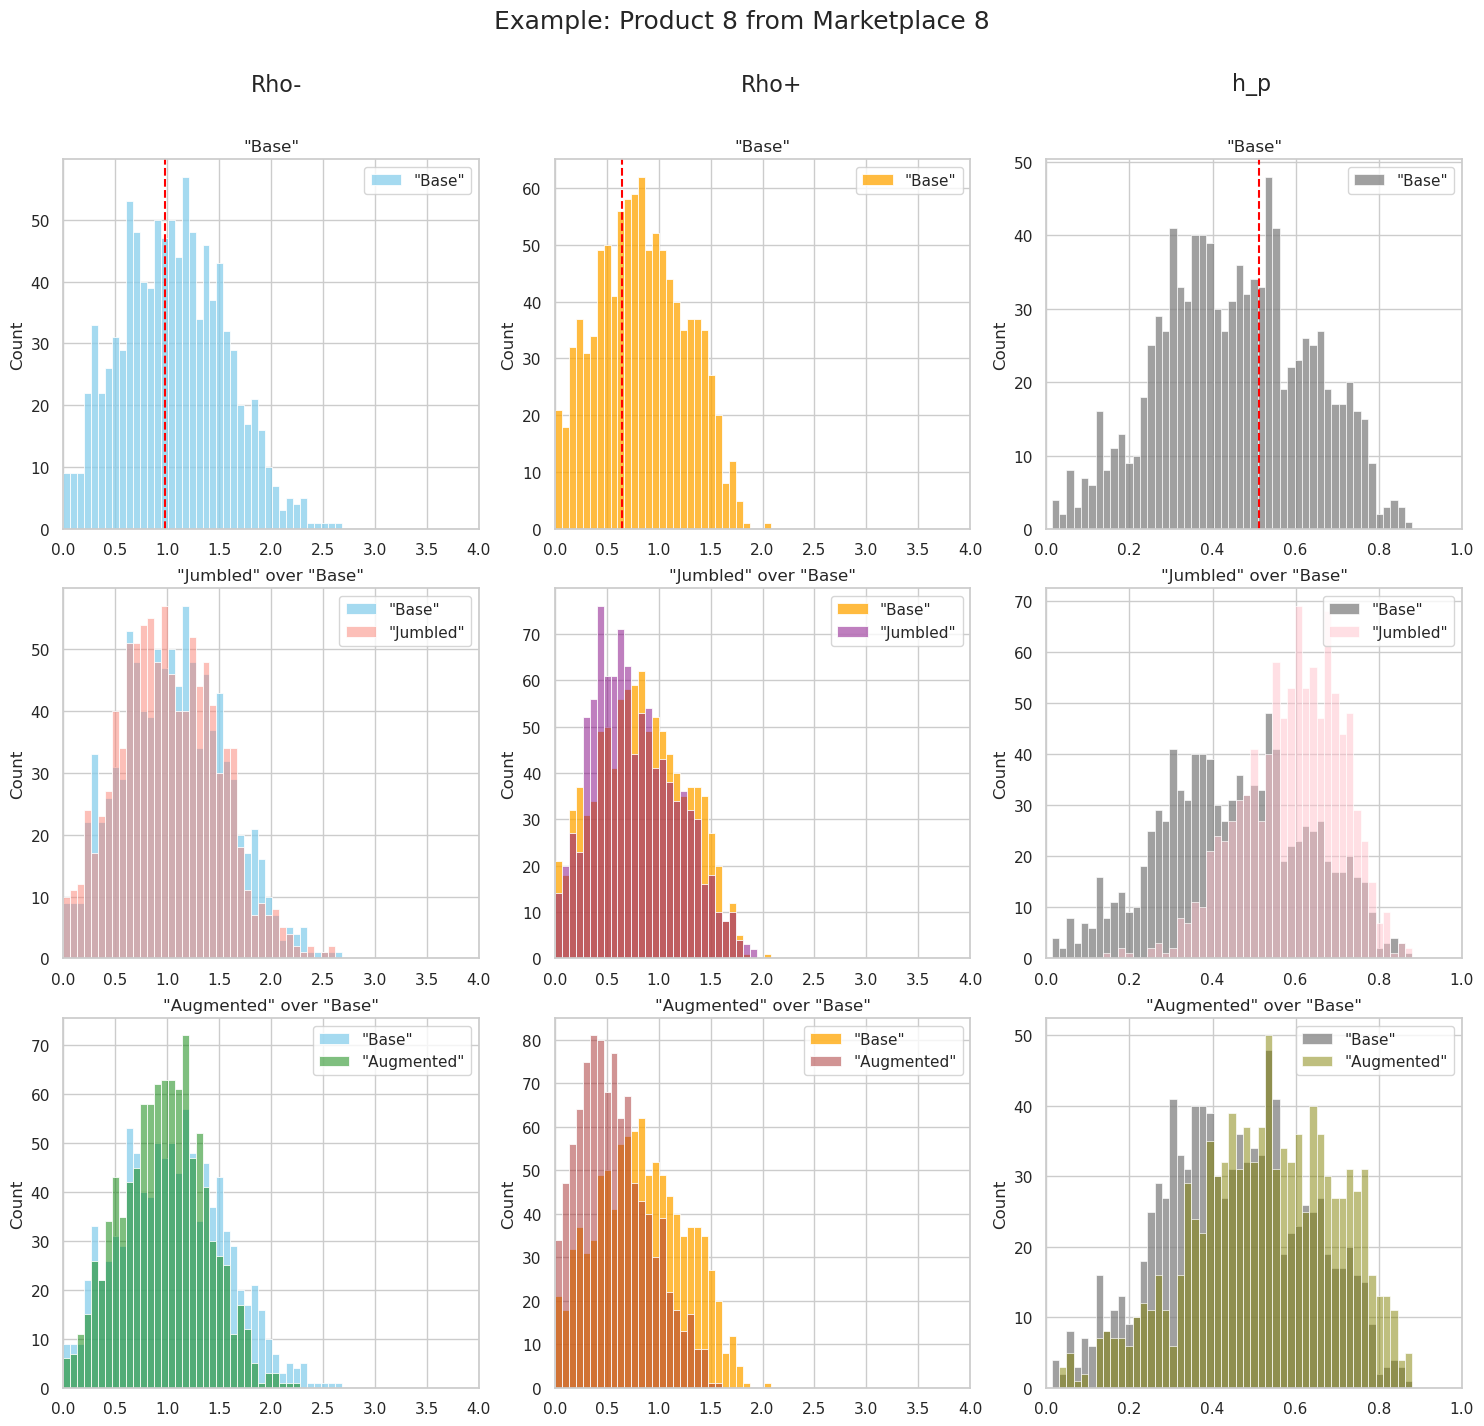

In [56]:
plot_rho_distributions_nineway(posterior_samples_base[:, :, 0], # Base rho-
                                posterior_samples_exp1[:, :, 0], # Jumbled rho -
                                posterior_samples_exp2[:, :, 0], # Augmented rho -
                                posterior_samples_base[:, :, 1], # Base rho +
                                posterior_samples_exp1[:, :, 1], # Jumbled rho +
                                posterior_samples_exp2[:, :, 1], # Augmented rho +
                                posterior_samples_base[:, :, 2], # Base h_p
                                posterior_samples_exp1[:, :, 2], # Jumbled h_p
                                posterior_samples_exp2[:, :, 2], # Augmented h_p
                                product,
                                marketplace,
                                real_rho_values,
                                real_hp_values)